In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, RocCurveDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction import DictVectorizer
import matplotlib.pyplot as plt
import seaborn as sns

# Homework

> Note: sometimes your answer doesn't match one of 
> the options exactly. That's fine. 
> Select the option that's closest to your solution.

In this homework, we will use the lead scoring dataset. Download it from [here](https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv).


In this dataset our desired target for classification task will be `converted` variable - has the client signed up to the platform or not. 

In [10]:
# seed
SEED = 1

# download
csv_file_name = "course_lead_scoring.csv"
!wget -O {csv_file_name} https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv

--2025-10-21 21:48:53--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8003::154, 2606:50c0:8000::154, 2606:50c0:8001::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8003::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 80876 (79K) [text/plain]
Saving to: ‘course_lead_scoring.csv’

course_lead_scoring 100%[===================>]  78,98K  --.-KB/s    in 0,04s   

2025-10-21 21:48:53 (2,10 MB/s) - ‘course_lead_scoring.csv’ saved [80876/80876]



## Data preparation

* Check if the missing values are presented in the features.
* If there are missing values:
    * For caterogiral features, replace them with 'NA'
    * For numerical features, replace with with 0.0 

Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use `train_test_split` function for that with `random_state=1`

In [ ]:
# load into panda
df = pd.read_csv(csv_file_name)
target = "converted"

# create list of categorical and numerical features
categorical_features = df.select_dtypes(
    include=["object", "category", "bool"]
).columns.tolist()
numerical_features = df.select_dtypes(include=["int64", "float64"]).columns.tolist()
if target in categorical_features:
    categorical_features.remove(target)
elif target in numerical_features:
    numerical_features.remove(target)

df[categorical_features] = df[categorical_features].fillna("NA")
df[numerical_features] = df[numerical_features].fillna(0.0)

# sanity check
if len(df.columns) - len(categorical_features) - len(numerical_features) - 1 != 0:
    raise RuntimeWarning("Something is off with the number of columns")


def my_split(df, target, test_size, val_size, seed=SEED):
    df_full_train, df_test = train_test_split(
        df, test_size=test_size, random_state=seed
    )
    df_train, df_val = train_test_split(
        df_full_train, test_size=val_size / (1 - test_size), random_state=seed
    )
    # train, val, test
    return (
        df_train.drop(columns=[target]),
        df_train[target].values,
        df_val.drop(columns=[target]),
        df_val[target].values,
        df_test.drop(columns=[target]),
        df_test[target].values,
    )


df_train, y_train, df_val, y_val, df_test, y_test = my_split(df, target, 0.2, 0.2)

# sanity check
print(
    f"relative sizes train, val, test: {np.array([len(df_train), len(df_val), len(df_test)]) / (len(df_train) + len(df_val) + len(df_test))}"
)

relative sizes train, val, test: [0.59917921 0.2004104  0.2004104 ]


In [12]:
len(df_train), len(df_val), len(df_test)

(876, 293, 293)

In [13]:
df.isna().sum()

lead_source                 0
industry                    0
number_of_courses_viewed    0
annual_income               0
employment_status           0
location                    0
interaction_count           0
lead_score                  0
converted                   0
dtype: int64

## Question 1: ROC AUC feature importance

ROC AUC could also be used to evaluate feature importance of numerical variables. 

Let's do that

* For each numerical variable, use it as score (aka prediction) and compute the AUC with the `y` variable as ground truth.
* Use the training dataset for that


If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. `-df_train['balance']`)

AUC can go below 0.5 if the variable is negatively correlated with the target variable. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

In [14]:
feature_scores = {}
for variable in numerical_features:
    roc_score = roc_auc_score(y_train, df_train[variable].values)
    roc_score = 1 - roc_score if roc_score < 0.5 else roc_score
    feature_scores[variable] = roc_score

dict(sorted(feature_scores.items(), key=lambda item: item[1], reverse=True))

{'number_of_courses_viewed': 0.7635680590007088,
 'interaction_count': 0.738270176293409,
 'lead_score': 0.6144993577250176,
 'annual_income': 0.5519578313253012}

Which numerical variable (among the following 4) has the highest AUC?

- `lead_score`
- **`number_of_courses_viewed`**
- `interaction_count`
- `annual_income`

## Question 2: Training the model

Apply one-hot-encoding using `DictVectorizer` and train the logistic regression with these parameters:

```python
LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
```

In [22]:
def train(df, y, C=1.0, seed=SEED):

    dv = DictVectorizer(sparse=False)
    dicts = df.to_dict(orient="records")
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(
        solver="liblinear",
        C=C,
        max_iter=1000,
        random_state=seed,
    )
    model.fit(X_train, y)

    return dv, model


def predict(df, dv, model):
    dicts = df.to_dict(orient="records")

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred


dv, model = train(df_train, y_train)
y_pred = predict(df_val, dv, model)

roc = roc_auc_score(y_val, y_pred)

print(f"roc is {roc:.3f}")

roc is 0.817


What's the AUC of this model on the validation dataset? (round to 3 digits)

- 0.32
- 0.52
- 0.72
- 0.92

Hmmm... this looks bad. The computed roc-auc score is pretty much between the two options 0.72 and 0.92.
Let's plot the normal roc to see if anything fishy is going on

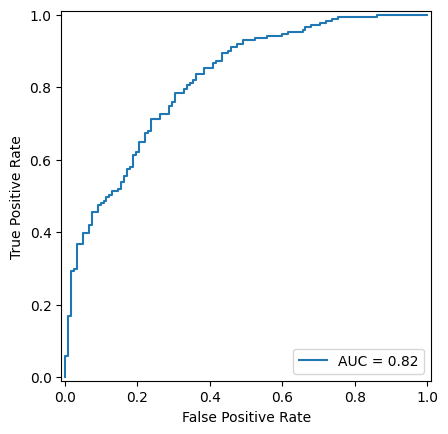

In [23]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc)
roc_display.plot()
plt.show()

Nah, can't seem to see anything fishy in there. Next, let's see if I screwed the seed up somehow. For that I make a histogram of the roc-auc for a bunch of seeds.

In [31]:
rocs = []
for seed in range(0, 9000):
    df_t, y_t, df_v, y_v, _, _ = my_split(df, target, 0.2, 0.2, seed=seed)
    dv, model = train(df_t, y_t, seed=seed)
    y_p = predict(df_v, dv, model)
    rocs.append(roc_auc_score(y_v, y_p))

min 0.7279368790181182, mean 0.8225262057195464,  max 0.9155440414507772


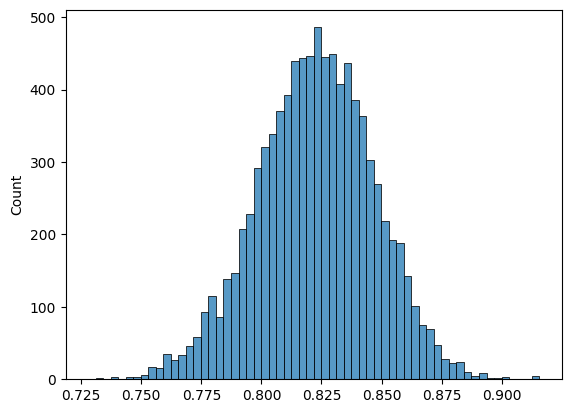

In [32]:
sns.histplot(rocs)
rocs = np.array(rocs)
print(f"min {rocs.min()}, mean {rocs.mean()},  max {rocs.max()}")

Damit. This doesn't tell me much either. The mean is very close to the middle. and the min or max are both greater and smaller than 0.72 and 0.92.

So at this point I can just guess, and I take 0.92 because the data is a tiny tiny bit in favour for it.

## Question 3: Precision and Recall

Now let's compute precision and recall for our model.

* Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall
* Plot them

0.64


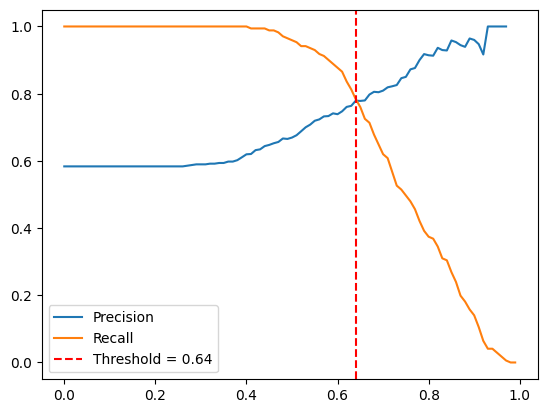

In [ ]:
def precision_recall_curve(y_pred, v_val):

    thresholds = np.arange(0.0, 1.0, 0.01)
    precisions = np.zeros(len(thresholds))  # precision = TP/(TP + FP)
    recalls = np.zeros(len(thresholds))  # recall = TP/(TP + FN)

    for i, t in enumerate(thresholds):
        predicts = y_pred >= t

        tp = (predicts & (y_val == 1)).sum()
        tn = (~predicts & (y_val == 0)).sum()

        fp = (predicts & (y_val == 0)).sum()
        fn = (~predicts & (y_val == 1)).sum()

        precision = tp / (tp + fp) if tp + fp > 0 else np.nan
        recall = tp / (tp + fn)

        precisions[i] = precision
        recalls[i] = recall

    # Find the threshold where precision and recall are closest
    diff = np.abs(precisions - recalls)
    closest_threshold_idx = np.nanargmin(diff)
    closest_threshold = thresholds[closest_threshold_idx]

    return thresholds, precisions, recalls, closest_threshold


thresholds, precisions, recalls, closest_threshold = precision_recall_curve(
    y_pred, y_val
)

plt.plot(thresholds, precisions, label="Precision")
plt.plot(thresholds, recalls, label="Recall")
plt.axvline(
    x=closest_threshold,
    color="red",
    linestyle="--",
    label=f"Threshold = {closest_threshold:.2f}",
)
plt.legend()

print(closest_threshold)

At which threshold precision and recall curves intersect?

* 0.145
* 0.345
* 0.545
* 0.745

Yei :/ We are in the middle again.

Ok, let's see if plotting a histogram will help with the decision.

In [83]:
closest_thresholds = []
for seed in range(0, 5000):
    df_t, y_t, df_v, y_v, _, _ = my_split(df, target, 0.2, 0.2, seed=seed)
    dv, model = train(df_t, y_t, seed=seed)
    y_p = predict(df_v, dv, model)
    _, _, _, closest_threshold = precision_recall_curve(y_p, y_v)
    closest_thresholds.append(closest_threshold)

<Axes: ylabel='Count'>

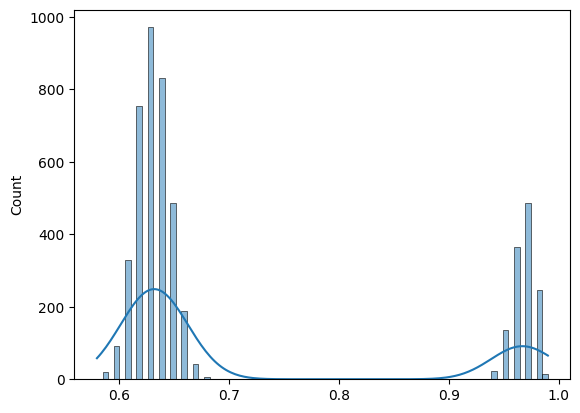

In [93]:
sns.histplot(closest_thresholds, bins=80, kde=True)

Wieder nicht schlauer. Der spike rechts sind fälle in denen der sich die Graphen sich zweimal schneidet und der zweite Schnittpunkt genommen wird. Wie unten

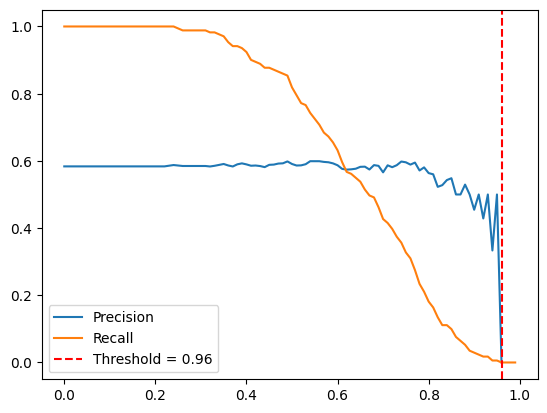

In [85]:
df_t, y_t, df_v, y_v, _, _ = my_split(df, target, 0.2, 0.2, seed=19)
dv, model = train(df_t, y_t, seed=seed)
y_p = predict(df_v, dv, model)

thresholds, precisions, recalls, closest_threshold = precision_recall_curve(y_p, y_v)

plt.plot(thresholds, precisions, label="Precision")
plt.plot(thresholds, recalls, label="Recall")
plt.axvline(
    x=closest_threshold,
    color="red",
    linestyle="--",
    label=f"Threshold = {closest_threshold:.2f}",
)
plt.legend()

Was wir also machen können ist abschneiden und dann wieder die Statistiken nach einen Trend anschauen.

In [ ]:
closest_thresholds = np.array(closest_thresholds)
filtered_thresholds = closest_thresholds[closest_thresholds <= 0.77]
print(
    f"min {filtered_thresholds.min()}, mean {filtered_thresholds.mean()},  max {filtered_thresholds.max()}"
)

min 0.58, mean 0.6321655024180548,  max 0.6900000000000001


Die Statistik sieht s besser als 0.545 etwas besser als 0.745.

## Question 4: F1 score

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

$$F_1 = 2 \cdot \cfrac{P \cdot R}{P + R}$$

Where $P$ is precision and $R$ is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01


0.5700000000000001


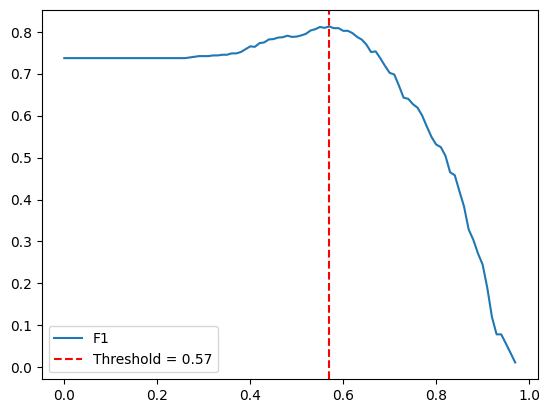

In [100]:
def f1_curve(y_pred, v_val):

    thresholds, precisions, recalls, _ = precision_recall_curve(y_pred, y_val)

    f1s = 2 * precisions * recalls / (precisions + recalls)
    max_f1_index = np.nanargmax(f1s)
    max_threshold = thresholds[max_f1_index]

    return thresholds, f1s, max_threshold


thresholds, f1s, max_threshold = f1_curve(y_pred, y_val)

plt.plot(thresholds, f1s, label="F1")
plt.axvline(
    x=max_threshold,
    color="red",
    linestyle="--",
    label=f"Threshold = {max_threshold:.2f}",
)
plt.legend()

print(max_threshold)

At which threshold F1 is maximal?

- 0.14
- 0.34
- **0.54**
- 0.74

### Question 5: 5-Fold CV


Use the `KFold` class from Scikit-Learn to evaluate our model on 5 different folds:

```
KFold(n_splits=5, shuffle=True, random_state=1)
```

* Iterate over different folds of `df_full_train`
* Split the data into train and validation
* Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
* Use AUC to evaluate the model on validation

In [109]:
from sklearn.model_selection import KFold

df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=seed)
y_full_train = df_full_train[target].values
df_full_train = df_full_train.drop(columns=[target])

kfold = KFold(n_splits=5, shuffle=True, random_state=SEED)
aucs = []
for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = y_full_train[train_idx]
    y_val = y_full_train[val_idx]

    dv, model = train(df_train, y_train)
    p_predict = predict(df_val, dv, model)

    aucs.append(roc_auc_score(y_val, p_predict))

print(f"mean: {np.mean(aucs):.2f}, std: {np.std(aucs):.3}")

mean: 0.83, std: 0.0302


How large is standard deviation of the scores across different folds?

- 0.0001
- 0.006
- **0.06**
- 0.36

### Question 6: Hyperparameter Tuning

Now let's use 5-Fold cross-validation to find the best parameter `C`

* Iterate over the following `C` values: `[0.000001, 0.001, 1]`
* Initialize `KFold` with the same parameters as previously
* Use these parameters for the model: `LogisticRegression(solver='liblinear', C=C, max_iter=1000)`
* Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

In [110]:
Cs = [0.000001, 0.001, 1]

for C in Cs:
    kfold = KFold(n_splits=5, shuffle=True, random_state=1)

    aucs = []
    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = y_full_train[train_idx]
        y_val = y_full_train[val_idx]

        dv, model = train(df_train, y_train, C=C)
        p_predict = predict(df_val, dv, model)

        aucs.append(roc_auc_score(y_val, p_predict))

    print(f"C: {C}, mean: {np.mean(aucs):.3f}, std: {np.std(aucs):.3f}")

C: 1e-06, mean: 0.547, std: 0.051
C: 0.001, mean: 0.871, std: 0.018
C: 1, mean: 0.832, std: 0.030


Which `C` leads to the best mean score?

- 0.000001
- **0.001**
- 1

If you have ties, select the score with the lowest std. If you still have ties, select the smallest `C`.

---

## Submit the results

* Submit your results here: https://courses.datatalks.club/ml-zoomcamp-2025/homework/hw04
* If your answer doesn't match options exactly, select the closest one